# Lane Detection Using CNN

In [1]:
# import the libaries

import numpy as np
import cv2,glob,os
import matplotlib.image as mpimg
# from scipy.misc import imresize
# from moviepy.editor import VideoFileClip
from IPython.display import HTML
from keras.models import model_from_json
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt


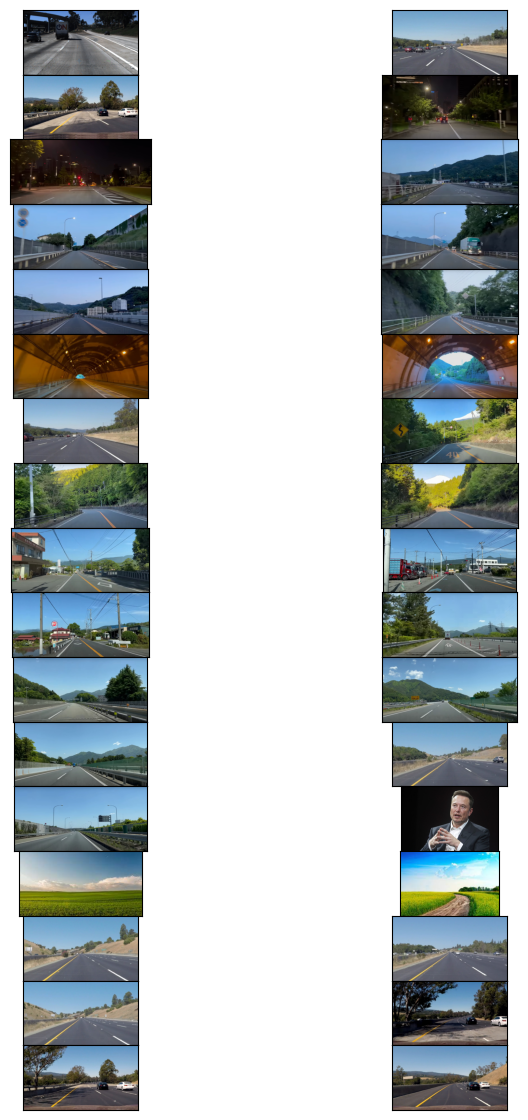

In [2]:
# plot the testing image

# show the images 
def show_images(images, cmap=None):
    cols = 2
    rows = (len(images)+1)//cols
    
    plt.figure(figsize=(10, 11))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        # use gray scale color map if there is only one channel
        cmap = 'gray' if len(image.shape)==2 else cmap
        plt.imshow(image, cmap=cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

test_images = [plt.imread(path) for path in glob.glob('test_images/*.jpg')]

show_images(test_images)

In [3]:
# Load pretrained model

# load the model json file 
json_file = open('model.json', 'r')
json_model = json_file.read()
json_file.close()

# load the model from the json
model = model_from_json(json_model)
# load the wieghts of the model
model.load_weights('model.h5')
images = []
for path in glob.glob('test_images/*.jpg'):

    img_arr = cv2.imread(path)
    actual_image = cv2.resize(img_arr, (1280, 720),
               interpolation = cv2.INTER_LINEAR)
#     imresize(img_arr, (720, 1280, 3))

    # Get image ready for feeding into model
    img = mpimg.imread(path)
    small_img_2 = cv2.resize(img, (160, 80), interpolation = cv2.INTER_LINEAR)
#     imresize(img, (80, 160, 3))
    small_img_1= np.array(small_img_2)
    small_img = small_img_1[None, :, :, :]
    images.append(small_img)
model.compile(optimizer="adam")
# model.evaluate(images[0])

In [4]:
# create a class Lane 

# Class to average lanes with
class Lanes():
    def __init__(self):
        self.recent_fit = []
        self.avg_fit = []

In [5]:
# resize the image and predict the lane to be drawn from the model in G color

def road_lines_image(image):
    
    img_arr = cv2.imread(image)
    actual_image = cv2.resize(img_arr, (1280, 720),
               interpolation = cv2.INTER_LINEAR)
#     imresize(img_arr, (720, 1280, 3))

    # Get image ready for feeding into model
    img = mpimg.imread(image)
    small_img_2 = cv2.resize(img, (160, 80), interpolation = cv2.INTER_LINEAR)
#     imresize(img, (80, 160, 3))
    small_img_1= np.array(small_img_2)
    small_img = small_img_1[None, :, :, :]

    # Make prediction with neural network (un-normalize value by multiplying by 255)
    prediction = model.predict(small_img)[0] * 255

    # Add lane prediction to list for averaging
    lanes.recent_fit.append(prediction)
    # Only using last five for average
    if len(lanes.recent_fit) > 5:
        lanes.recent_fit = lanes.recent_fit[1:]

    # Calculate average detection
    lanes.avg_fit = np.mean(np.array([i for i in lanes.recent_fit]), axis = 0)

    # Generate fake R & B color dimensions, stack with G
    blanks = np.zeros_like(lanes.avg_fit).astype(np.uint8)
    lane_drawn = np.dstack((blanks, lanes.avg_fit, blanks))

    # Re-size to match the original image
    lane_image = cv2.resize(lane_drawn, (1280, 720),
               interpolation = cv2.INTER_LINEAR)
#     imresize(lane_drawn, (720, 1280, 3))

    # Merge the lane drawing onto the original image
    lane_image = lane_image.astype(actual_image.dtype)
    result = cv2.addWeighted(actual_image, 1, lane_image, 1, 0)

    return result

In [6]:
# predict the lane detector 

#create a lanes object
lanes = Lanes()

for path in glob.glob('test_images/*.jpg'):
    res_img = road_lines_image(path)
    names = [os.path.basename(x) for x in glob.glob(path)]   
    out_path = 'test_predict/'+names[0]
    # save the result in a image
    cv2.imwrite(out_path, res_img.astype(np.uint8))
   

1/1 [==============================] - 0s 49ms/step


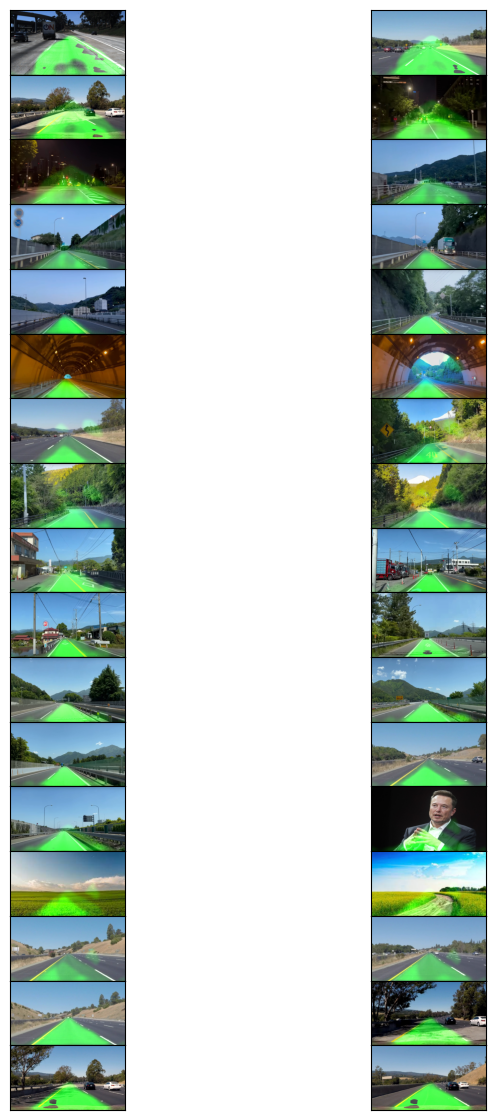

In [7]:
# plot the predicted result

predicted_images = [plt.imread(path) for path in glob.glob('test_predict/*.jpg')]

show_images(predicted_images)

In [10]:
# Assuming y_true and y_pred are your true and predicted labels, respectively
y_true=[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,1,1,1,1,1]
y_pred=[0,0,0,1,1,1,1,1,1,1,1,1,0,0,1,1,0,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1]
cm = confusion_matrix(y_true, y_pred)
print(cm)


[[ 2  1]
 [ 6 24]]


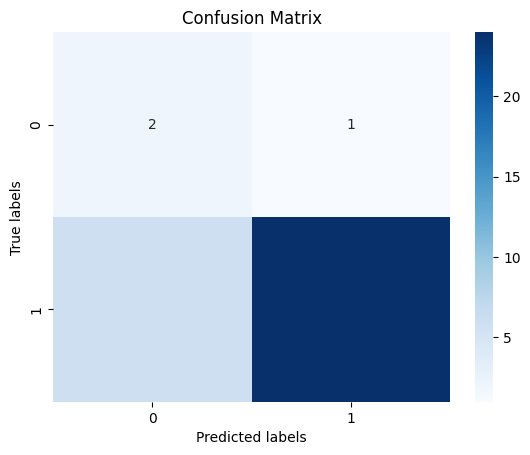

In [11]:
# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display confusion matrix as a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [12]:
accuracy = accuracy_score(y_true, y_pred)
# Compute precision
precision = precision_score(y_true, y_pred)

# Compute recall
recall = recall_score(y_true, y_pred)

# Compute F1 score
f1 = f1_score(y_true, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.7878787878787878
Precision: 0.96
Recall: 0.8
F1 Score: 0.8727272727272728
